In [ ]:
!pip install py-pde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.2/352.2 KB 32.8 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FFMpegWriter
import math
plt.rcParams['animation.ffmpeg_path'] = "./ffmpeg-5.1.1-amd64-static/ffmpeg"

In [ ]:
#constants
mol = 6.02214e23

h=15e-9
r = 2.2e-7 #radius of synaptic cleft

ratio = r/h
print(ratio)

area = np.pi*r**2 #Area of synpactiv cleft
V=np.pi*h*r**2

dc = 8e-7 # diffusion coefficient

receptor_density = 1000*math.pow(10,12) #Density of receptors, measured in number per m^2
R = receptor_density*np.pi*r**2 #The actual amount of receptors on the membrane
N = 5000 #mol of neurotransmitters released
free_items = R+N
print(N)
print(R)


k_on = 4e6 #Reaction constant on binding, measured in l/mol/s, could be changed to meters
k_on = 4e6*math.pow(10,-3)#10e-3 #changed to m^3/(mol s)

#This means we need to just find the amount of mol per m^3 close to the receptors
k_off = 5 #Measured in s^-1

bound_receptors_transmission = 0.5 #Minimum fraction of bound receptors necessary to trigger transmission


14.666666666666668
5000
152.053084433746


In [42]:
import numba as nb
import numpy as np
import pde
import sys
from pde import FieldCollection, PDEBase, PlotTracker, ScalarField, UnitGrid, CartesianGrid, ScalarField, MemoryStorage, FileStorage,plot_kymograph


class NeuroTransmitters3D(PDEBase):
    def __init__(self, k_on, k_off, diffusitivity, bc="auto_periodic_neumann"):
        super().__init__()
        self.k_on = k_on
        self.k_off = k_off
        self.diffusitivity = diffusitivity  # spatial mobility
        self.bc = bc  # boundary condition
        self.initial_free_receptors = None

    def get_initial_state(self, grid):
        """prepare a useful initial state"""
        shape = grid.shape
        n = ScalarField(grid, 0, label="Field $n$")
        r = ScalarField(grid, 0, label="Field $r$")
        spacing = shape[0]
        for i in range(spacing):
            n.insert(point=np.array([i*grid.radius/spacing, 0]), amount=N/spacing) #inserting evenly spaced
            r.insert(point=np.array([i*grid.radius/spacing, grid.axes_bounds[1][1]]), amount=R/spacing) #R is the amount of receptors, add them on the other side
        rn = ScalarField(grid, 0, label="Field $rn$") #This is just 0 in the beginning
        self.initial_free_receptors = np.sum(r.data)
        return FieldCollection([n,r,rn])

    def evolution_rate(self, state, t=0):
        """pure python implementation of the PDE"""
        n, r, rn = state
        rhs = state.copy()
        d = self.diffusitivity

        if r.integral <= bound_receptors_transmission * self.initial_free_receptors:
            print(f'Signal is sendt at t={t}')
            #sys.exit()

        binding = r*n*k_on
        unbinding = rn*k_off

        rhs[0] = d*n.laplace(self.bc) - binding + unbinding
        rhs[1] = - binding + unbinding
        rhs[2] =  binding - unbinding
        return rhs

    def _make_pde_rhs_numba(self, state):
        """nunmba-compiled implementation of the PDE"""
        d0 = self.diffusitivity
        self.k_on = k_on
        self.k_off = k_off
        laplace = state.grid.make_operator("laplace", bc=self.bc)

        @nb.jit()
        def pde_rhs(state_data, t):
            n = state_data[0]
            r = state_data[1]
            rn = state_data[2]
            d = self.diffusitivity

            if np.sum(r) <= bound_receptors_transmission * self.initial_free_receptors:
                print(np.sum(r))
                print(f'Signal is sendt at t={t}')
                #sys.exit()

            binding = r*n*k_on
            unbinding = rn*k_off
            rate = np.empty_like(state_data)
            rate[0] = d*laplace(n) - binding + unbinding
            rate[1] = - binding + unbinding
            rate[2] =  binding - unbinding
            return rate

        return pde_rhs
size=10
radius=int(ratio)*size
height = size

total=math.pow(10,-5)
n=100
dt = total/n

dc=8e-7
dc_dimless = dc*dt/(r*h)

print(dc_dimless)
k_on_new = k_on/(mol*V)*np.pi*radius**2*height
k_on_new = 4e3*dt/mol
print(k_on_new)

k_off_new = k_off*dt
print(k_off_new)

grid = pde.CylindricalSymGrid(radius=r, bounds_z=(0,h), shape=[height, radius])
# Set zero Neumann boundary conditions (particles can't escape domain)

bc = {"derivative": 0}

storage = FileStorage("3dNeuro.npz")

eq = NeuroTransmitters3D(k_on_new, k_off_new,diffusitivity=dc_dimless, bc=bc)
state = eq.get_initial_state(grid)

# simulate the pde
tracker = PlotTracker(interval=total/2, show=True,output_file="test.png")
sol = eq.solve(state, t_range=total, dt=total/n,tracker=storage.tracker(interval=total/10), method="explicit")


24.242424242424242
6.642157106942051e-28
5.000000000000001e-07
Signal is sendt at t=0
/tmp/ipykernel_91/201033988.py:55: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "pde_rhs" failed type inference due to: Untyped global name 'self': Cannot determine Numba type of <class '__main__.NeuroTransmitters3D'>

File "../tmp/ipykernel_91/201033988.py", line 60:
<source missing, REPL/exec in use?>

  @nb.jit()
/root/venv/lib/python3.9/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "pde_rhs" was compiled in object mode without forceobj=True.

File "../tmp/ipykernel_91/201033988.py", line 55:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/root/venv/lib/python3.9/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected, this is deprecated behaviour.

For more inf

100%|██████████| 11/11 [00:05<00:00,  1.83it/s]
Showing first field since argument `field_index` is missing. Use `plot_kymographs` to show kymographs of multiple fields.


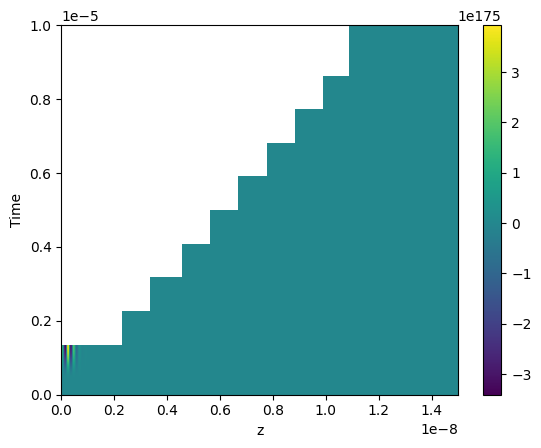

In [ ]:
pde.movie(storage, filename="3dNeuro.mov")
# plot the resulting field

# visualize the result in a space-time plot
plot_kymograph(storage)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8fa4b93d-2b12-4306-b794-0842afddf55c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>